In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

DATA_DIR = '/content/drive/MyDrive/patterns'
print(os.listdir(DATA_DIR))

['pattern_dataset', 'pattern _dataset_5k']


In [ ]:
print(os.listdir(DATA_DIR+'/pattern _dataset_5k')[:10])

['SK-10A-23-BLACK-1.jpg', 'SK-10-23-2-Cream-1.jpg', 'SK-07A-23-BEIGE-1.jpg', 'SK-22-23-2-LemonYellow--1.jpg', 'SFLR-17.1-22-2-yellow.jpg', 'SFLR-52.1-23-White.jpg', 'SFLR-17.1-23-Magenta.jpg', 'SK-16-23-2-Black-1.jpg', 'SLR-19-23-3-Light_Pink-1_63e882d6-4425-4b04-80b6-5d6dc24a95d5.jpg', 'SLR-100-24-Beige-1.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


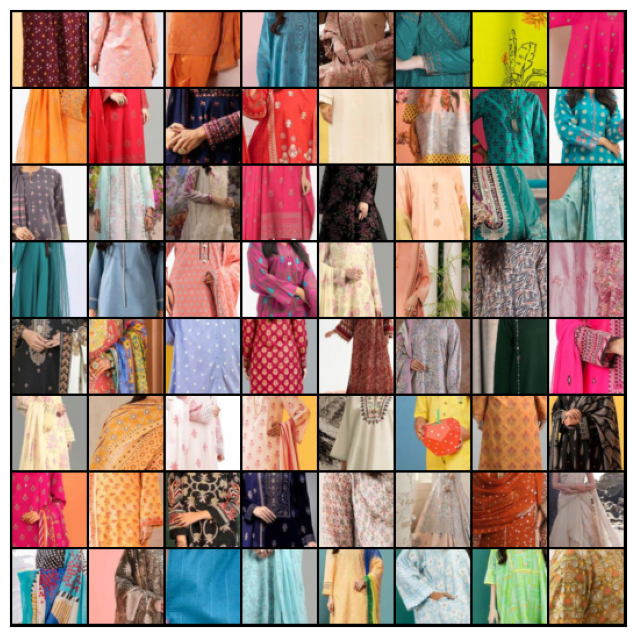

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

show_batch(train_dl)


In [ ]:
!pip install jovian --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device
train_dl = DeviceDataLoader(train_dl, device)


In [ ]:
import torch.nn as nn

discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


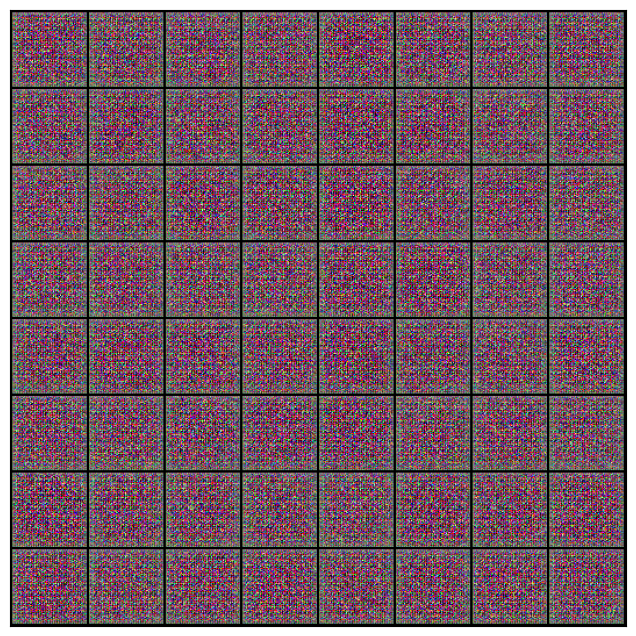

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

Saving generated-images-0000.png


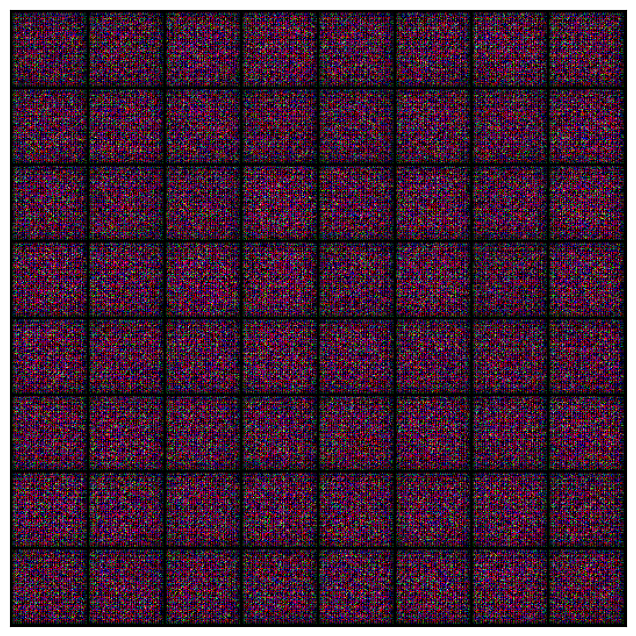

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores


In [ ]:
lr = 0.0002
epochs =230

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [1/230], loss_g: 15.9535, loss_d: 0.1043, real_score: 0.9043, fake_score: 0.0000
Saving generated-images-0001.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [2/230], loss_g: 1.8175, loss_d: 1.1748, real_score: 0.4863, fake_score: 0.0740
Saving generated-images-0002.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [3/230], loss_g: 10.9512, loss_d: 1.0577, real_score: 0.9789, fake_score: 0.6241
Saving generated-images-0003.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [4/230], loss_g: 4.8931, loss_d: 0.2322, real_score: 0.9349, fake_score: 0.1485
Saving generated-images-0004.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [5/230], loss_g: 4.3884, loss_d: 0.3924, real_score: 0.9899, fake_score: 0.2899
Saving generated-images-0005.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [6/230], loss_g: 2.2021, loss_d: 0.7768, real_score: 0.6114, fake_score: 0.1412
Saving generated-images-0006.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [7/230], loss_g: 2.4988, loss_d: 0.6357, real_score: 0.6484, fake_score: 0.1375
Saving generated-images-0007.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [8/230], loss_g: 2.3980, loss_d: 0.5453, real_score: 0.7030, fake_score: 0.1293
Saving generated-images-0008.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [9/230], loss_g: 4.2124, loss_d: 0.9813, real_score: 0.8665, fake_score: 0.5337
Saving generated-images-0009.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [10/230], loss_g: 2.5760, loss_d: 0.6921, real_score: 0.6536, fake_score: 0.1816
Saving generated-images-0010.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [11/230], loss_g: 4.8869, loss_d: 1.3514, real_score: 0.9531, fake_score: 0.6881
Saving generated-images-0011.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [12/230], loss_g: 1.9442, loss_d: 0.8650, real_score: 0.6378, fake_score: 0.2627
Saving generated-images-0012.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [13/230], loss_g: 5.6132, loss_d: 1.1166, real_score: 0.8967, fake_score: 0.6019
Saving generated-images-0013.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [14/230], loss_g: 2.1152, loss_d: 1.1656, real_score: 0.4014, fake_score: 0.0362
Saving generated-images-0014.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [15/230], loss_g: 3.3238, loss_d: 0.5802, real_score: 0.8193, fake_score: 0.2754
Saving generated-images-0015.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [16/230], loss_g: 2.6807, loss_d: 0.5157, real_score: 0.7305, fake_score: 0.1444
Saving generated-images-0016.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [17/230], loss_g: 2.4046, loss_d: 0.6090, real_score: 0.6329, fake_score: 0.0891
Saving generated-images-0017.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [18/230], loss_g: 3.9021, loss_d: 0.4803, real_score: 0.7312, fake_score: 0.1042
Saving generated-images-0018.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [19/230], loss_g: 4.8505, loss_d: 0.5248, real_score: 0.8586, fake_score: 0.2823
Saving generated-images-0019.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [20/230], loss_g: 2.1418, loss_d: 0.5399, real_score: 0.6993, fake_score: 0.1254
Saving generated-images-0020.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [21/230], loss_g: 3.8102, loss_d: 0.9282, real_score: 0.6662, fake_score: 0.3435
Saving generated-images-0021.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [22/230], loss_g: 6.7694, loss_d: 1.1968, real_score: 0.8977, fake_score: 0.5970
Saving generated-images-0022.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [23/230], loss_g: 4.0940, loss_d: 0.4793, real_score: 0.8965, fake_score: 0.2854
Saving generated-images-0023.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [24/230], loss_g: 3.8894, loss_d: 0.4911, real_score: 0.7758, fake_score: 0.1769
Saving generated-images-0024.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [25/230], loss_g: 3.5346, loss_d: 0.4279, real_score: 0.7985, fake_score: 0.1589
Saving generated-images-0025.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [26/230], loss_g: 2.8640, loss_d: 1.1127, real_score: 0.3966, fake_score: 0.0052
Saving generated-images-0026.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [27/230], loss_g: 3.8904, loss_d: 1.2339, real_score: 0.3562, fake_score: 0.0088
Saving generated-images-0027.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [28/230], loss_g: 2.8059, loss_d: 0.3845, real_score: 0.8378, fake_score: 0.1668
Saving generated-images-0028.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [29/230], loss_g: 4.0561, loss_d: 0.4305, real_score: 0.8536, fake_score: 0.2141
Saving generated-images-0029.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [30/230], loss_g: 3.5583, loss_d: 0.6338, real_score: 0.7820, fake_score: 0.2599
Saving generated-images-0030.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [31/230], loss_g: 3.7817, loss_d: 0.4615, real_score: 0.8333, fake_score: 0.2231
Saving generated-images-0031.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [32/230], loss_g: 3.7288, loss_d: 0.5479, real_score: 0.9354, fake_score: 0.3271
Saving generated-images-0032.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [33/230], loss_g: 3.0966, loss_d: 0.8489, real_score: 0.4737, fake_score: 0.0072
Saving generated-images-0033.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [34/230], loss_g: 7.9487, loss_d: 0.9459, real_score: 0.9383, fake_score: 0.5467
Saving generated-images-0034.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [35/230], loss_g: 3.2642, loss_d: 0.2693, real_score: 0.8351, fake_score: 0.0686
Saving generated-images-0035.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [36/230], loss_g: 3.3347, loss_d: 0.4471, real_score: 0.7114, fake_score: 0.0678
Saving generated-images-0036.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [37/230], loss_g: 2.8971, loss_d: 0.4056, real_score: 0.7664, fake_score: 0.0977
Saving generated-images-0037.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [38/230], loss_g: 6.3750, loss_d: 0.9270, real_score: 0.8990, fake_score: 0.5103
Saving generated-images-0038.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [39/230], loss_g: 3.6862, loss_d: 0.3386, real_score: 0.8249, fake_score: 0.1046
Saving generated-images-0039.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [40/230], loss_g: 2.8305, loss_d: 0.5969, real_score: 0.5908, fake_score: 0.0208
Saving generated-images-0040.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [41/230], loss_g: 3.1149, loss_d: 0.4453, real_score: 0.8202, fake_score: 0.1870
Saving generated-images-0041.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [42/230], loss_g: 3.4754, loss_d: 0.3310, real_score: 0.8240, fake_score: 0.1145
Saving generated-images-0042.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [43/230], loss_g: 3.3133, loss_d: 0.5842, real_score: 0.7277, fake_score: 0.1836
Saving generated-images-0043.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [44/230], loss_g: 0.4338, loss_d: 1.5278, real_score: 0.2734, fake_score: 0.0019
Saving generated-images-0044.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [45/230], loss_g: 1.8107, loss_d: 1.0409, real_score: 0.4273, fake_score: 0.0047
Saving generated-images-0045.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [46/230], loss_g: 2.9951, loss_d: 0.4643, real_score: 0.7967, fake_score: 0.1902
Saving generated-images-0046.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [47/230], loss_g: 2.2016, loss_d: 0.3175, real_score: 0.7979, fake_score: 0.0696
Saving generated-images-0047.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [48/230], loss_g: 3.5608, loss_d: 0.3017, real_score: 0.7924, fake_score: 0.0434
Saving generated-images-0048.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [49/230], loss_g: 3.5460, loss_d: 0.1798, real_score: 0.9303, fake_score: 0.0953
Saving generated-images-0049.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [50/230], loss_g: 3.6674, loss_d: 0.2158, real_score: 0.9087, fake_score: 0.1022
Saving generated-images-0050.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [51/230], loss_g: 2.3306, loss_d: 0.4113, real_score: 0.8215, fake_score: 0.1538
Saving generated-images-0051.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [52/230], loss_g: 3.1760, loss_d: 0.2255, real_score: 0.8482, fake_score: 0.0420
Saving generated-images-0052.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [53/230], loss_g: 1.9581, loss_d: 0.3212, real_score: 0.7799, fake_score: 0.0522
Saving generated-images-0053.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [54/230], loss_g: 6.9428, loss_d: 0.3831, real_score: 0.9780, fake_score: 0.2786
Saving generated-images-0054.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [55/230], loss_g: 3.5247, loss_d: 0.2738, real_score: 0.8393, fake_score: 0.0740
Saving generated-images-0055.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [56/230], loss_g: 0.7589, loss_d: 1.8211, real_score: 0.2184, fake_score: 0.0040
Saving generated-images-0056.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [57/230], loss_g: 2.9402, loss_d: 1.5270, real_score: 0.2795, fake_score: 0.0025
Saving generated-images-0057.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [58/230], loss_g: 3.0526, loss_d: 0.1245, real_score: 0.9710, fake_score: 0.0875
Saving generated-images-0058.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [59/230], loss_g: 6.2825, loss_d: 0.6603, real_score: 0.9585, fake_score: 0.4179
Saving generated-images-0059.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [60/230], loss_g: 4.0648, loss_d: 0.1585, real_score: 0.9297, fake_score: 0.0771
Saving generated-images-0060.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [61/230], loss_g: 4.5518, loss_d: 0.0704, real_score: 0.9670, fake_score: 0.0349
Saving generated-images-0061.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [62/230], loss_g: 3.0111, loss_d: 0.2433, real_score: 0.9194, fake_score: 0.1352
Saving generated-images-0062.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [63/230], loss_g: 2.0192, loss_d: 0.3928, real_score: 0.7222, fake_score: 0.0342
Saving generated-images-0063.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [64/230], loss_g: 2.1134, loss_d: 0.2835, real_score: 0.8305, fake_score: 0.0719
Saving generated-images-0064.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [65/230], loss_g: 5.3586, loss_d: 0.5553, real_score: 0.9305, fake_score: 0.3345
Saving generated-images-0065.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [66/230], loss_g: 5.0730, loss_d: 0.1784, real_score: 0.8519, fake_score: 0.0093
Saving generated-images-0066.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [67/230], loss_g: 4.7170, loss_d: 0.2137, real_score: 0.9583, fake_score: 0.1478
Saving generated-images-0067.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [68/230], loss_g: 3.1992, loss_d: 0.0802, real_score: 0.9447, fake_score: 0.0204
Saving generated-images-0068.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [69/230], loss_g: 4.2306, loss_d: 0.0888, real_score: 0.9363, fake_score: 0.0208
Saving generated-images-0069.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [70/230], loss_g: 6.2555, loss_d: 1.2383, real_score: 0.9786, fake_score: 0.6236
Saving generated-images-0070.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [71/230], loss_g: 2.2431, loss_d: 0.5284, real_score: 0.6564, fake_score: 0.0257
Saving generated-images-0071.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [72/230], loss_g: 3.8482, loss_d: 0.1488, real_score: 0.9682, fake_score: 0.1023
Saving generated-images-0072.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [73/230], loss_g: 5.8298, loss_d: 0.0645, real_score: 0.9864, fake_score: 0.0484
Saving generated-images-0073.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [74/230], loss_g: 4.2699, loss_d: 0.0826, real_score: 0.9734, fake_score: 0.0527
Saving generated-images-0074.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [75/230], loss_g: 6.1542, loss_d: 1.6689, real_score: 0.9674, fake_score: 0.6251
Saving generated-images-0075.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [76/230], loss_g: 6.1972, loss_d: 0.2464, real_score: 0.9843, fake_score: 0.1919
Saving generated-images-0076.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [77/230], loss_g: 5.1292, loss_d: 0.0435, real_score: 0.9729, fake_score: 0.0154
Saving generated-images-0077.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [78/230], loss_g: 12.7762, loss_d: 5.0499, real_score: 1.0000, fake_score: 0.9819
Saving generated-images-0078.png


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch [79/230], loss_g: 4.4513, loss_d: 0.1829, real_score: 0.9665, fake_score: 0.1325
Saving generated-images-0079.png


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
from IPython.display import Image

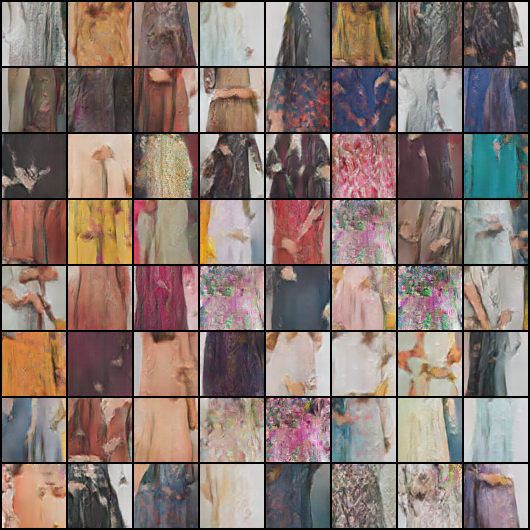

In [ ]:
Image('./generated/generated-images-0230.png')

In [ ]:
import os
import imageio
from IPython.display import Image, display

folder_path = '/content/drive/MyDrive/generated'

output_gif = 'gans_training.gif'

image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.png')]

image_files.sort()

images = []

for image_file in image_files:
    images.append(imageio.imread(image_file))

imageio.mimsave(output_gif, images)

print("GIF created successfully!")


<ipython-input-25-ada8cb236eb7>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(image_file))


GIF created successfully!


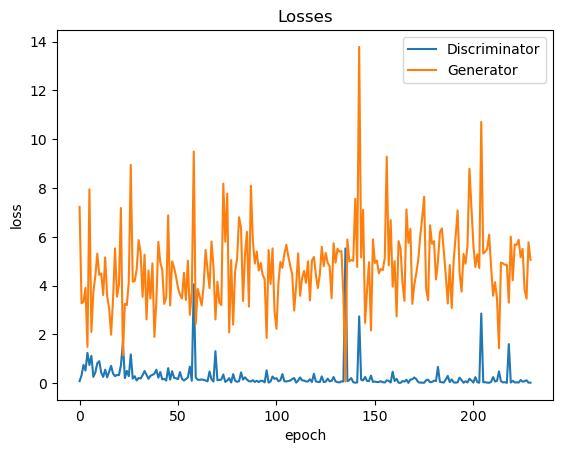

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

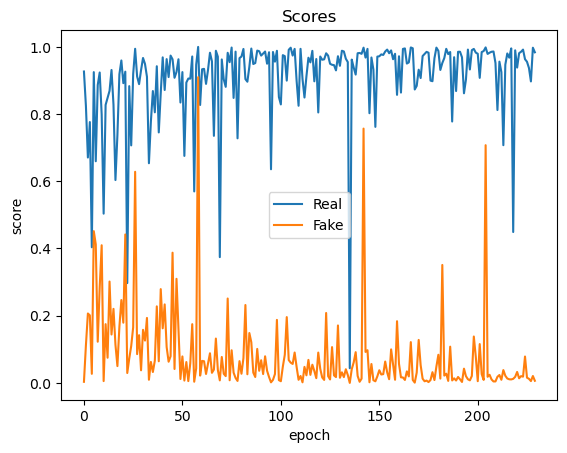

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');